# 1. 기초 통계 과제 
### Iris 데이터셋을 활용해 클래스별 변수 평균 차이를 검정

#### 1-1. 데이터셋 구조 확인

In [9]:
import seaborn as sns
import pandas as pd

In [10]:
iris = sns.load_dataset('iris')
print(iris.head())

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [12]:
print(iris.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


#### 1-2. 기술통계량 산출

In [13]:
group_stats = iris.groupby('species')['petal_length'].describe()
print(group_stats)

            count   mean       std  min  25%   50%    75%  max
species                                                       
setosa       50.0  1.462  0.173664  1.0  1.4  1.50  1.575  1.9
versicolor   50.0  4.260  0.469911  3.0  4.0  4.35  4.600  5.1
virginica    50.0  5.552  0.551895  4.5  5.1  5.55  5.875  6.9


In [14]:
#그룹별 데이터 개수 확인
print(iris['species'].value_counts())

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


#### 1-3. 시각화

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Distribution of Petal Length by Iris Species')

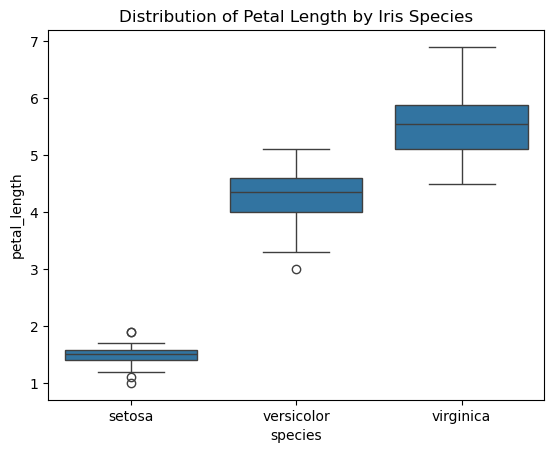

In [17]:
sns.boxplot(x='species', y='petal_length', data=iris)
plt.title("Distribution of Petal Length by Iris Species")

petal length의 평균은 virginica가 가장 크고, Setosa가 가장 작다.\
Setosa는 중앙값이 가장 낮고, 분산이 작아 꽃잎 길이가 짧고 일정하게 분포함을 보여준다.\
Virginica는 가장 높은 중앙값과 넓은 분포 범위를 나타낸다.

#### 1-4. 정규성 검정 

In [18]:
from scipy.stats import shapiro

가설\
H₀: 해당 종(Species)의 Petal Length 데이터는 정규분포를 따른다.\
H₁: 해당 종의 Petal Length 데이터는 정규분포를 따르지 않는다.

In [20]:
for species in iris['species'].unique():
    data = iris[iris['species'] == species]['petal_length']
    stat, p = shapiro(data)

    print(f"{species}: p-value = {p:.4f}")

setosa: p-value = 0.0548
versicolor: p-value = 0.1585
virginica: p-value = 0.1098


모든 그룹에서 Shapiro-Wilk 검정의 p-value가 0.05보다 크므로, 세 그룹 모두에서 정규성을 만족한다고 판단할 수 있다. 

#### 1-5. 등분산성 검정

가설\
H₀: 세 그룹의 분산이 모두 같다. \
H₁: 적어도 하나의 그룹은 분산이 다르다. 

In [22]:
from scipy.stats import levene
setosa = iris[iris['species']== 'setosa']['petal_length']
versicolor = iris[iris['species']== 'versicolor']['petal_length']
virginica = iris[iris['species']== 'virginica']['petal_length']

stat, p = levene(setosa, versicolor, virginica) 
print(f"p-value = {p:.8f}")


p-value = 0.00000003


해석 \
p-value가 유의수준 0.05보다 작으므로, 귀무가설을 기각한다.\
따라서 세 그룹 간 분산이 같지 않다고 판단할 수 있다. 


#### 1-6. ANOVA 가설 수립

가설\
H₀: 3개 species 간의 petal length 평균은 모두 같다. \
H₁: 적어도 한 species의 petal length 평균은 나머지와 다르다.  

#### 1-7. ANOVA 실행 

In [23]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

model = ols('petal_length ~ species', data=iris).fit() 
annova_table = sm.stats.anova_lm(model, typ=2)
print(annova_table)

            sum_sq     df            F        PR(>F)
species   437.1028    2.0  1180.161182  2.856777e-91
Residual   27.2226  147.0          NaN           NaN


해석\
p-value가 유의수준 0.05보다 작기 때문에 귀무가설을 기각한다.\
종에 따라 꽃잎 길이의 평균에 통계적으로 유의미한 차이가 존재한다. 

#### 1-8. 사후검정

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=iris['petal_length'], groups=iris['species'], alpha=0.05)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor    2.798   0.0 2.5942 3.0018   True
    setosa  virginica     4.09   0.0 3.8862 4.2938   True
versicolor  virginica    1.292   0.0 1.0882 1.4958   True
---------------------------------------------------------


모든 그룹 쌍에서 p-value가 0.05보다 작고, 평균 차이에 대한 95% 신뢰구간이 0을 포함하지 않는다. 따라서 모든 쌍에서 통계적으로 유의미한 평균 차이가 존재한다. 



#### 1-9. 결과 요약

Iris 데이터셋을 활용하여 세 종(setosa, versicolor, virginica) 간의 petal length 평균 차이가 존재하는지 통계적으로 검정했다.
1. Boxplot 시각화를 통해 virginica 품종이 가장 긴 petal length를, setosa가 가장 짧은 petal length를 가짐을 확인하였다. 
2. One-way ANOVA 분석을 통해 세 품종 간 평균 petal length의 차이가 통계적으로 유의미함을 확인하였다(p<0.05)
3. Tukey의 사후검정에서 모든 품종 쌍 간에 유의한 평균 차이가 존재함을 확인하였다. 

따라서 세 품종의 평균 petal length는 통계적으로 유의미한 차이가 있으며,setosa < versicolor < virginica 순으로 petal length가 유의미하게 길다는 것을 확인하였다. 

# 2. 기초 머신러닝 과제 
### 실제 신용카드 사기 데이터셋을 활용해 클래스 불균형 상황에서 분류 모델을 학습

#### 2-1. 데이터 로드 및 기본 탐색 

In [26]:
#라이브러리 불러오기 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
df = pd.read_csv('creditcard.csv')
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [30]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [33]:
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [34]:
print(df['Class'].value_counts(normalize=True))

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [35]:
#정상 거래와 사기 거래 건수 확인 
count_by_class = df['Class'].value_counts()
print("정상 거래 (Class=0):", count_by_class[0])
print("사기 거래 (Class=1):", count_by_class[1])

정상 거래 (Class=0): 284315
사기 거래 (Class=1): 492


creditcard.csv 파일을 불러온 후, 전체 데이터의 구조와 클래스 분포를 확인하였다.\
총 284,807건의 거래가 포함되어 있으며, class 분포를 확인한 결과, 정상 거래가 99.8% 이상을 차지하고, 사기 거래는 약 0.17%로 매우 희소하게 나타났다. 


#### 2-2. 샘플링

In [38]:
#사기 거래만 추출 
fraud = df[df['Class'] == 1]

#정상 거래 중 10,000건 무작위로 추출 
normal = df[df['Class'] == 0].sample(n=10000, random_state=42)

# 사기 + 샘플링된 정상 거래 
sampled_df = pd.concat([fraud, normal])
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [39]:
# 새 데이터셋의 클래스 비율 확인 
print(sampled_df['Class'].value_counts(normalize=True))

Class
0    0.953107
1    0.046893
Name: proportion, dtype: float64


사기 거래 전체와 정상 거래 10,000건을 샘플링하여 약 4.7%의 사기 거래 비율을 갖는 샘플 데이터셋을 구성하였다.\
 원본 데이터에 비해 class 1이 크게 보강된 것을 확인하였다. 

#### 2-3. 데이터 전처리

In [37]:
from sklearn.preprocessing import StandardScaler

In [40]:
#StandardScaler 객체 생성 
scaler = StandardScaler()

#Amount 변수 표준화, 새로운 열 Amount_Scaled로 저장 
sampled_df['Amount_Scaled'] = scaler.fit_transform(sampled_df[['Amount']])

#기존 Amount 열 제거
sampled_df = sampled_df.drop(columns=['Amount'])

#X, y 분리 
X = sampled_df.drop(columns=['Class'])
y = sampled_df['Class']


#### 2-4. 학습 데이터와 테스트 데이터 분할

In [53]:
from sklearn.model_selection import train_test_split

In [42]:
#학습셋 80%, 테스트셋 20%로 분할
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

In [43]:
#학습셋 클래스 비율 확인 
print(y_train.value_counts(normalize = True))

Class
0    0.953056
1    0.046944
Name: proportion, dtype: float64


In [44]:
#테스트셋 클래스 비율 확인 
print(y_test.value_counts(normalize=True))

Class
0    0.953311
1    0.046689
Name: proportion, dtype: float64


#### 2-5. SMOTE 적용 

SMOTE는 소수 클래스의 데이터를 새로 합성함으로써, 클래스 불균형 문제를 완화하는 방법이다.

현재 학습 데이터에서는 사기 거래(Class=1)의 비율이 매우 낮아, 모델이 해당 클래스의 패턴을 제대로 학습하지 못할 우려가 있다. 
이에 따라 SMOTE를 적용하여 소수 클래스 샘플을 합성하고, 정상 거래(class=0)와 유사한 수준으로 클래스 분포를 조정할 필요가 있다. 

In [46]:
from imblearn.over_sampling import SMOTE

In [47]:
#SMOTE 객체 생성 
smote = SMOTE(random_state=42)

#학습 데이터에 SMOTE 적용 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [48]:
#SMOTE 적용 전/후 클래스 개수 비교 
print("SMOTE 적용 전:")
print(y_train.value_counts())

print("\nSMOTE 적용 후:")
print(y_train_smote.value_counts())

SMOTE 적용 전:
Class
0    7999
1     394
Name: count, dtype: int64

SMOTE 적용 후:
Class
0    7999
1    7999
Name: count, dtype: int64


SMOTE 적용 결과, 학습 데이터에서 소수 클래스였던 사기 거래(Class=1)가 394건에서 7,999건으로 합성되어, 두 클래스가 1:1 비율로 균형 맞춰졌다.

#### 2-6. 모델 학습 

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, average_precision_score

In [63]:
#모델 정의
model = RandomForestClassifier(random_state=42)

#모델 학습 
model.fit(X_train_smote, y_train_smote)

#얘측값 및 예측 확률
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("예측값:", y_pred[:10])
print("예측 확률", y_proba[:10])


예측값: [0 0 0 0 0 0 1 0 0 0]
예측 확률 [0.01 0.   0.01 0.   0.   0.01 0.99 0.   0.05 0.  ]


In [64]:
#평가 지표 

print("Classification Report:")
print(classification_report(y_test, y_pred))


print("\n PR-AUC:")
print(average_precision_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2001
           1       0.98      0.83      0.90        98

    accuracy                           0.99      2099
   macro avg       0.98      0.91      0.95      2099
weighted avg       0.99      0.99      0.99      2099


 PR-AUC:
0.9156887960343137


#### 2-7. 최종 성능 평가 

신용카드 거래 데이터에서 사기 거래(Class=1)를 탐지하기 위해 Random Forest 모델을 활용하였다.\
초기 데이터셋은 총 284,807건의 거래로 구성되어 있었으며, 이 중 사기 거래는 약 0.17%에 불과해 클래스 불균형 문제가 존재했다.\
이를 해결하기 위해, 정상 거래 중 10,000건을 무작위 추출하고 사기 거래는 전부 유지하여 샘플링된 데이터셋을 구성하였다. 이후 SMOTE를 적용하여 소수 클래스(Class=1)의 데이터를 합성하고, 학습 데이터의 클래스 분포를 균형 있게 맞췄다.\

이러한 전처리 과정을 거친 후, 랜덤 포레스트 모델을 학습하고 테스트셋에 대해 예측을 수행한 결과는 다음과 같다:

Class1(사기거래)
- Recall : 0.83
- F1-score: 0.90
- PR-AUC: 0.9157

Class0(정상거래)
- Recall : 1.00
- F1-score: 1.00

모든 성능 지표가 제시된 기준(Recall ≥ 0.80, F1 ≥ 0.88, PR-AUC ≥ 0.90)을 만족하였다. 
따라서, 해당 모델이 정상 거래와 사기 거래를 모두 높은 정확도로 분류할 수 있는 신뢰도 높은 분류 모델임을 확인할 수 있었다. 

